# Predicting and Analyzing Urban Tree Health in Washington, D.C.

- Author: [Justin Schroder](https://github.com/SchroderJ-pixel)
- Repository: [Urban-Tree-Health-](https://github.com/SchroderJ-pixel/Urban-Tree-Health-)

## Section 1. Introduction

TODO: Remove this and customize your intro: Introduce the purpose of your project and provide background information on data sources, etc. 
The purpose of this notebook is to introduce notebooks for analytics. 
This is a Markdown cell (not a Python cell). 
Here are a few tips to help you get started with Jupyter Notebooks:

- To run a cell, press **Ctrl Enter** (or **Cmd Enter** on Mac) when you're done editing the cell.
- You can change the type of a cell (e.g., code or markdown) by looking in the lower left corner of the notebook interface.
- You can rearrange cells by dragging and dropping them within the notebook.
- After creating a new notebook, use **File > Save as** to rename and save it into your repository folder.
- To select a kernel (Python environment) for your notebook in Visual Studio Code, click on the **Select Kernel** name in the top-right corner of the notebook interface and choose the desired kernel from the dropdown menu. Follow suggestions to install recommended extensions. Once installed, click Select Kernel / Python Environments and choose the Recommended local project `.venv` created earlier. This will create a new kernel for the notebook and allow code to use the packages installed in the virtual environment.

## Section 2. Imports 

### 2.1 Import Libraries 

In [24]:
# 2.1 Imports
import os
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

pd.set_option("display.float_format", lambda x: f"{x:.3f}")
sns.set_theme(context="notebook", style="whitegrid")


## Section 3 Data Preparation
### 3.1 Import & Load Dataset for 5M Urban Trees (Washington, D.C.)

In [25]:
# 2.2 Import Dataset
DATA_DIR = r"C:\Users\admin\OneDrive\Desktop\Masters\Capstone\Urban-Tree-Health\data"
CSV_PATH = os.path.join(DATA_DIR, "urban_trees.csv")
PARQUET_PATH = os.path.join(DATA_DIR, "urban_trees.parquet")

READ_KW = dict(
    infer_schema_length=50000,   # give Polars more rows to infer types
    null_values=["NA", "N/A", "", "na"],  # treat these as nulls
    try_parse_dates=True,
    ignore_errors=False,
)

if os.path.exists(PARQUET_PATH):
    df_pl = pl.read_parquet(PARQUET_PATH)
else:
    df_pl = pl.read_csv(CSV_PATH, **READ_KW)
    try:
        df_pl.write_parquet(PARQUET_PATH)
    except Exception as e:
        print("Skipped Parquet write:", e)

df = df_pl.to_pandas()
print("✅ Data Loaded")
print(f"Rows: {len(df):,} | Columns: {df.shape[1]}")
df.head(10)



✅ Data Loaded
Rows: 190,991 | Columns: 17


,city_ID,planted_date,most_recent_observation,common_name,scientific_name,city,state,longitude_coordinate,latitude_coordinate,address,ward,overhead_utility,diameter_breast_height_CM,condition,native,diameter_breast_height_binned_CM,greater_metro
0,15297-200-3001-0323-000,1/1/1970,1/15/2020,Pin oak,Quercus palustris,Washington DC,District of Columbia,-77.046,38.933,2020 Klingle rd Nw,1.000,No,67.310,good,naturally_occurring,60.96 to 76.2 cm,WashingtonDC
1,15297-200-3001-0279-000,1/1/1970,5/11/2020,Pin oak,Quercus palustris,Washington DC,District of Columbia,-77.046,38.933,2016 Klingle rd Nw,1.000,No,57.658,good,naturally_occurring,45.72 to 60.96 cm,WashingtonDC
2,36981-060-3001-0097-000,12/15/2014,12/30/2019,Nuttall oak,Quercus nuttallii,Washington DC,District of Columbia,-76.998,38.886,600 Pennsylvania Ave Se,6.000,No,12.700,good,None,0 to 15.24 cm,WashingtonDC
3,19048-300-3001-0321-000,1/1/1970,1/15/2020,Red oak,Quercus rubra,Washington DC,District of Columbia,-77.045,38.932,3226 Walbridge Pl Nw,1.000,No,27.940,good,naturally_occurring,15.24 to 30.48 cm,WashingtonDC
4,10170-310-3005-0211-000,1/1/1970,4/24/2019,Bradford callery pear,Pyrus calleryana,Washington DC,District of Columbia,-77.039,38.929,3105 17th St Nw,1.000,No,22.860,fair,introduced,15.24 to 30.48 cm,WashingtonDC
5,15297-200-3005-0194-000,1/1/1970,1/15/2020,Chinese elm,Ulmus parvifolia,Washington DC,District of Columbia,-77.046,38.933,2011 Klingle rd Nw,1.000,Yes,39.878,excellent,introduced,30.48 to 45.72 cm,WashingtonDC
6,30050-020-3001-0328-000,1/1/1970,12/14/2015,Littleleaf linden,Tilia cordata,Washington DC,District of Columbia,-76.999,38.887,226 5th St Se,6.000,No,36.576,good,introduced,30.48 to 45.72 cm,WashingtonDC
7,31982-060-3005-0468-000,12/4/2017,9/26/2018,Hackberry,Celtis occidentalis,Washington DC,District of Columbia,-76.997,38.886,649 C St Se,6.000,No,3.810,good,naturally_occurring,0 to 15.24 cm,WashingtonDC
8,17702-200-3005-0419-000,1/26/2018,1/15/2020,New harmony elm,Ulmus americana,Washington DC,District of Columbia,-77.047,38.934,2037 Rosemount Ave Nw,1.000,No,5.080,excellent,naturally_occurring,0 to 15.24 cm,WashingtonDC
9,16253-310-3005-0307-000,3/11/2010,4/24/2017,Plane tree,Platanus,Washington DC,District of Columbia,-77.038,38.930,3131 Mount Pleasant St Nw,1.000,No,10.160,fair,None,0 to 15.24 cm,WashingtonDC


### 3.2 View Data Types

In [26]:
df.dtypes

city_ID                              object
planted_date                         object
most_recent_observation              object
common_name                          object
scientific_name                      object
city                                 object
state                                object
longitude_coordinate                float64
latitude_coordinate                 float64
address                              object
ward                                float64
overhead_utility                     object
diameter_breast_height_CM           float64
condition                            object
native                               object
diameter_breast_height_binned_CM     object
greater_metro                        object
dtype: object

## Section 3. Data Description

TODO: Remove this: This is a Markdown cell. Describe your data source, count of rows, each attribute / feature / column.

TODO: Remove this and provide your data description below.  
This analysis uses the built-in `penguins` dataset from the Seaborn package.  
It is a clean, well-structured dataset collected by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER program. The data describe physical measurements for penguins from three species observed on three islands in the Palmer Archipelago, Antarctica.

The dataset includes approximately **344 rows** (individual penguins) and **7 columns** (attributes):

| Column | Type | Description |
|---------|------|-------------|
| `species` | categorical | Penguin species: *Adelie*, *Chinstrap*, or *Gentoo*. |
| `island` | categorical | Island where the penguin was observed (*Biscoe*, *Dream*, or *Torgersen*). |
| `bill_length_mm` | numeric (float) | Length of the penguin's bill (culmen) in millimeters. |
| `bill_depth_mm` | numeric (float) | Depth (height) of the bill in millimeters. |
| `flipper_length_mm` | numeric (int) | Length of the flipper in millimeters. |
| `body_mass_g` | numeric (int) | Body mass in grams. |
| `sex` | categorical | Penguin's sex (*Male* or *Female*); some values are missing. |

### Notes
- Some rows include **missing values** for `sex` and certain measurements; these should be handled before statistical analysis.  
- A mix of **categorical** and **numeric** features makes this dataset useful for practicing data visualization, descriptive statistics, and basic analytics techniques.


## Section 4. Analysis and Visualization

TODO: Remove this: This is a Markdown cell. 

TODO: Introduce your analysis and visualization processes in clear, organized sections. Most will use more than one section for this part - adjust your headings accordingly. 

NameError: name 'Axes' is not defined

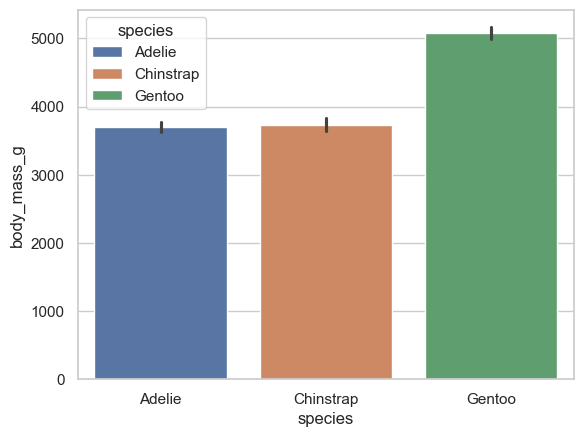

In [27]:
# This is a Python cell

# 1. Load a built-in dataset (many are available: 'penguins', 'tips', 'iris', 'flights', etc.)
df = sns.load_dataset("penguins")

# 2. Pick a built-in Seaborn theme for style
sns.set_theme(style="whitegrid")

# 3. Use Seaborn to create a bar chart, returns a set of axes
ax: Axes = sns.barplot(
    data=df,  # set chart data to our dataframe
    x="species",  # set chart x-axis to species column
    y="body_mass_g",  # set chart y-axis to body mass column
    hue="species",  # color by species
    palette="deep",  # choose a color palette (many built-in options available)
    legend="full",  # show full legend with all categories
)

# 4. Add numeric labels above each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", label_type="edge", padding=2)  # type: ignore

# 5. Add titles and labels
plt.title("Average Body Mass by Penguin Species")
plt.xlabel("Species")
plt.ylabel("Body Mass (g)")
plt.show()

## Section 5. Results and Conclusions

TODO: Remove this: This is a Markdown cell. At the end of your notebook, summarize practical insights gained from your analysis. Be specific, data-driven, and present what useful insights (based on specific results) your analysis has shown. Summarize for the reader so they don't have to review the entire analysis, but they can.

TODO: Summarize your specific results and conclusions clearly.
From the chart, we can see that Adelie and Chinstrap penguins have very similar average body mass, while the Gentoo penguins are noticeably heavier.  
On average, Gentoo penguins weigh roughly **20% more** than the other two species.  


## Before Committing: Finalize and Run All before sending to GitHub

TODO: Remove this whole cell or confirm that you have reviewed your notebook for quality. This is a Markdown cell. Before committing a notebook, use 'Run All' to generate all outputs and display them in the notebook. Verify everything looks right before using git add-commit-push to save your work to GitHub. Confirm title block and intro are good, section headings are clear, visuals have clear captions, labels, axes, units, and legends. Professional analysis skills and professional communication skills are critical. 
